# Analyse Exploratoire des Données - Classification

**Dataset utilisé** : Corporate Credit Rating - https://www.kaggle.com/datasets/agewerc/corporate-credit-rating

## Pourquoi faire cette analyse exploratoire ?

Dans ce projet, on va utiliser la **Prédiction Conforme pour la Classification** pour évaluer le rating de crédit des entreprises. Contrairement à un modèle de classification classique qui prédit une seule classe, la prédiction conforme nous donne un **ensemble de classes possibles** avec une garantie statistique de couverture.

### Prédiction Conforme en Classification

Au lieu de dire "cette entreprise est de classe A", on va dire "cette entreprise appartient probablement à {A, B}" avec un niveau de confiance de 90%. C'est beaucoup plus honnête et utile pour la prise de décision !

**Ce que l'EDA nous aide à comprendre :**

- **Distribution des classes** : Est-ce que notre dataset est déséquilibré ? Certaines classes sont-elles sur-représentées ?
- **Qualité des features** : Quelles variables permettent vraiment de séparer les classes ?
- **Séparabilité** : Est-ce que les classes sont bien distinctes ou se chevauchent-elles ?
- **Features discriminantes** : Identifier les variables qui ont le plus de pouvoir prédictif
- **Taille des ensembles de prédiction** : Si les classes se chevauchent beaucoup, nos ensembles de prédiction seront plus grands

**En gros** : Cette analyse va nous aider à construire un bon modèle sous-jacent pour la prédiction conforme, à comprendre pourquoi certaines prédictions auront plusieurs classes possibles, et à interpréter correctement les résultats.

## Plan de l'analyse
1. Charger et préparer les données
2. Analyser la distribution de la variable cible (équilibre des classes)
3. Regarder comment les variables explicatives sont distribuées
4. Étudier la relation entre chaque feature et les classes cibles
5. Identifier les features les plus discriminantes

In [62]:
# Imports
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from data_loading import load_classification_data

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [63]:
# Chargement et identification de la variable cible
df = load_classification_data()
print(f"Dataset shape: {df.shape}")

print("Columns in the dataset:")
print(df.columns.tolist())

Chargement du dataset de classification: /home/r-one/Documents/epita/stochastique/Prediction-Conforme-et-Regression-Quantile-sur-le-Risque-de-Credit/data/raw/corporate_rating.csv
Dataset chargé: 2029 lignes, 31 colonnes
Dataset shape: (2029, 31)
Columns in the dataset:
['Rating', 'Name', 'Symbol', 'Rating Agency Name', 'Date', 'Sector', 'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding', 'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin', 'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed', 'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover', 'debtEquityRatio', 'debtRatio', 'effectiveTaxRate', 'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare', 'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue', 'enterpriseValueMultiple', 'operatingCashFlowPerShare', 'operatingCashFlowSalesRatio', 'payablesTurnover']


On supprime les features qui sont juste des identifiants et qui n'apportent rien pour prédire le rating.

Ces colonnes (`Name`, `Symbol` et `Date`) ne contiennent que des informations nominatives ou temporelles qui ne sont pas pertinentes pour notre modèle.

In [64]:
if ('Name' in df.columns and 'Symbol' in df.columns and 'Date' in df.columns):
    df = df.drop(columns=['Name', 'Symbol', 'Date'])

In [65]:
# Identification de la variable cible
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

if len(categorical_cols) > 0:
    target_col = categorical_cols[0]  # Première catégorielle comme cible probable
    print(f"\nVariable cible: {target_col}")
    print(f"Classes: {df[target_col].value_counts()}")
else:
    target_col = df.columns[-1]  # Dernière colonne
    print(f"\nVariable cible: {target_col}")

# Variables pour l'analyse
other_categorical = [col for col in categorical_cols if col != target_col]
print(f"\nVariables numériques: {len(numeric_cols)}")
print(f"Variables catégorielles (hors cible): {len(other_categorical)}")


Variable cible: Rating
Classes: Rating
BBB    671
BB     490
A      398
B      302
AA      89
CCC     64
AAA      7
CC       5
C        2
D        1
Name: count, dtype: int64

Variables numériques: 25
Variables catégorielles (hors cible): 2


## Distribution des Features

Avant d'analyser la variable cible et son regroupement, visualisons la distribution de toutes nos variables numériques. Cela nous permettra de :

- **Détecter les outliers** : Identifier les valeurs extrêmes qui pourraient biaiser le modèle
- **Comprendre la forme des distributions** : Normale, asymétrique, bimodale...
- **Repérer les problèmes de données** : Valeurs manquantes, erreurs de mesure
- **Décider des transformations** : Log, standardisation, normalisation selon les besoins

=== DISTRIBUTIONS DES VARIABLES NUMÉRIQUES ===

Statistiques descriptives des variables numériques :
       currentRatio  quickRatio  cashRatio  daysOfSalesOutstanding  \
count       2029.00     2029.00    2029.00                 2029.00   
mean           3.53        2.65       0.67                  333.80   
std           44.05       32.94       3.58                 4447.84   
min           -0.93       -1.89      -0.19                 -811.85   
25%            1.07        0.60       0.13                   22.91   
50%            1.49        0.99       0.30                   42.37   
75%            2.17        1.45       0.62                   59.32   
max         1725.51     1139.54     125.92               115961.64   

       netProfitMargin  pretaxProfitMargin  grossProfitMargin  \
count          2029.00             2029.00            2029.00   
mean              0.28                0.43               0.50   
std               6.06                8.98               0.53   
min     

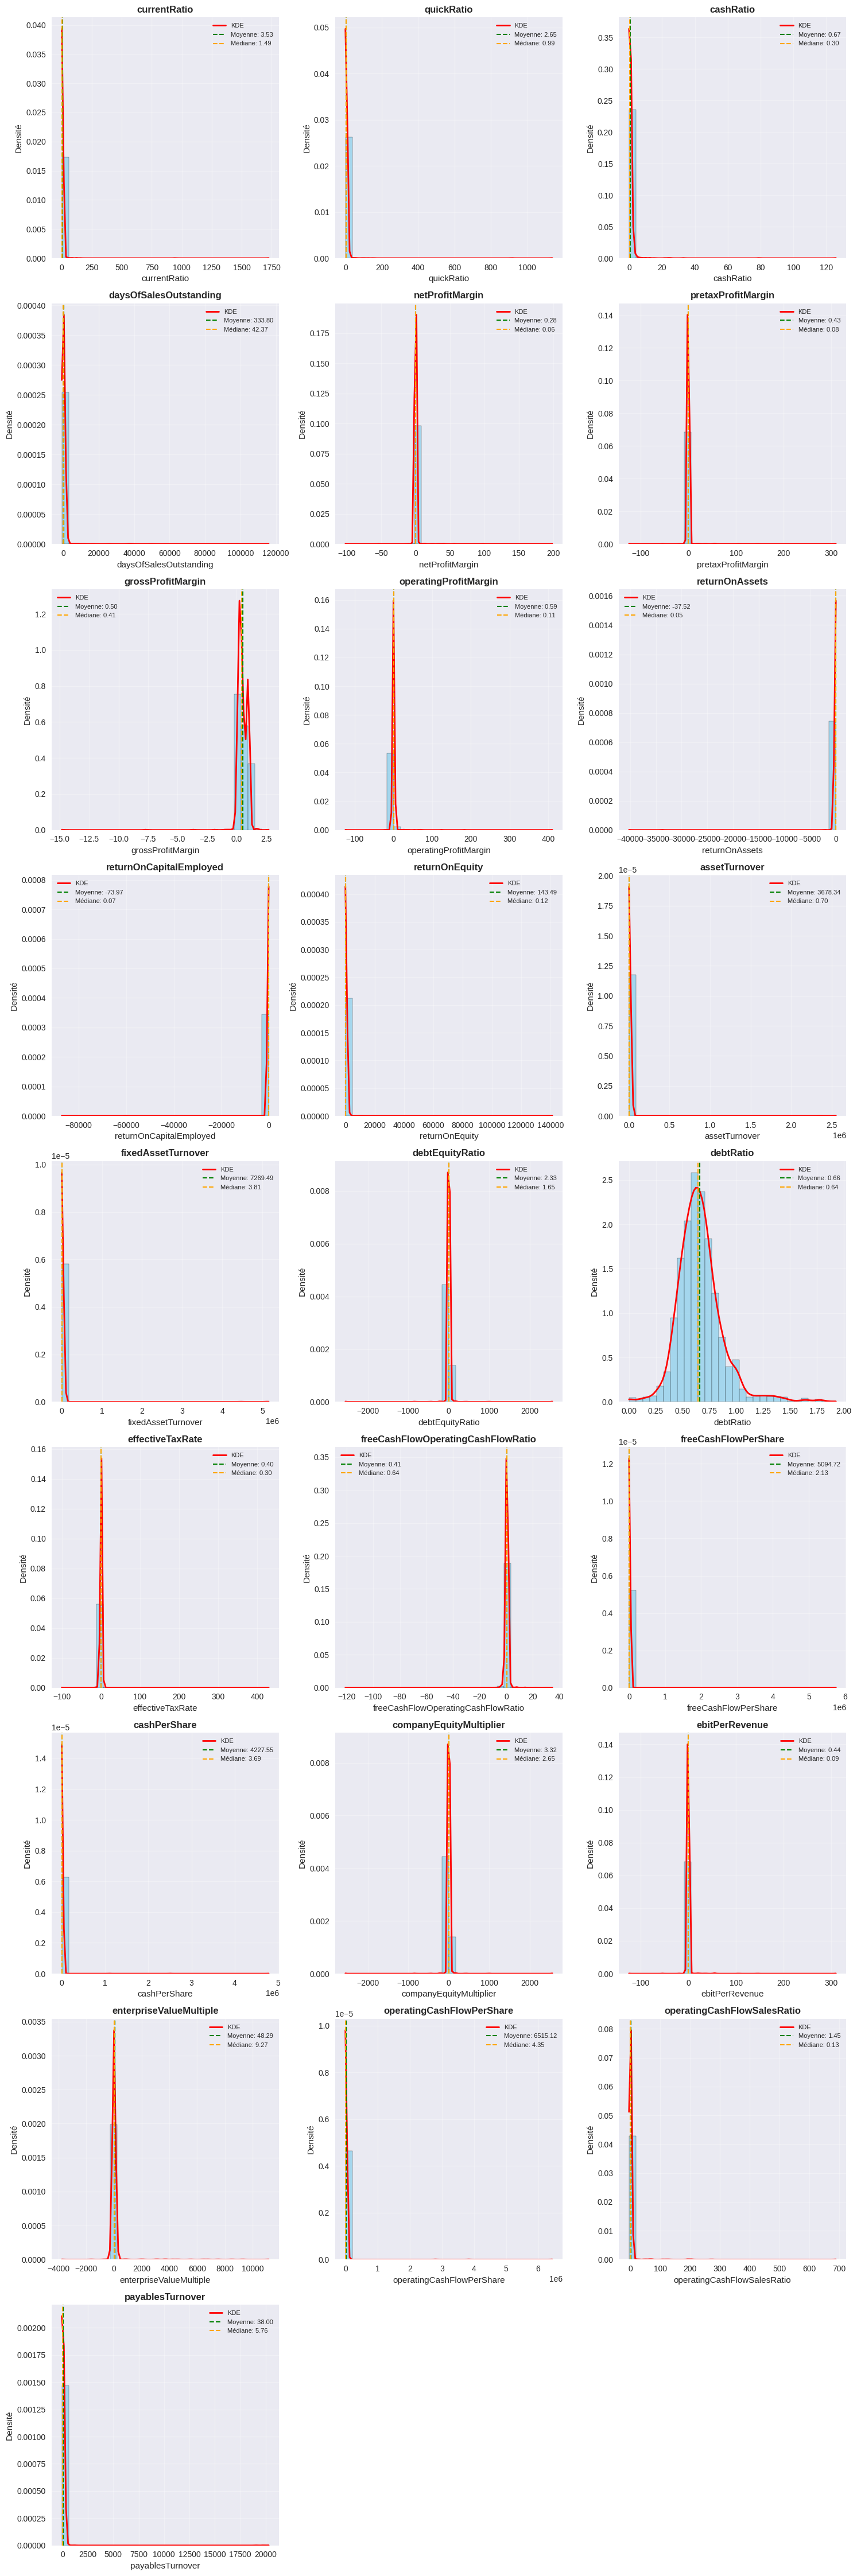

In [66]:
# Distribution des variables numériques
if len(numeric_cols) > 0:
    print("=== DISTRIBUTIONS DES VARIABLES NUMÉRIQUES ===\n")
    
    # Statistiques descriptives
    print("Statistiques descriptives des variables numériques :")
    print(df[numeric_cols].describe().round(2))
    
    # Distributions générales avec histogrammes
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5*n_rows))
    axes = axes.ravel() if len(numeric_cols) > 1 else [axes]
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            # Histogramme avec KDE (courbe de densité)
            axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
            
            # Ajouter une courbe de densité (KDE)
            try:
                from scipy import stats
                data = df[col].dropna()
                if len(data) > 1 and data.std() > 0:
                    kde = stats.gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 100)
                    axes[i].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
            except:
                pass
            
            axes[i].set_title(f'{col}', fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Densité')
            axes[i].grid(True, alpha=0.3)
            
            # Ajouter des statistiques dans le coin
            mean_val = df[col].mean()
            median_val = df[col].median()
            axes[i].axvline(mean_val, color='green', linestyle='--', linewidth=1.5, label=f'Moyenne: {mean_val:.2f}')
            axes[i].axvline(median_val, color='orange', linestyle='--', linewidth=1.5, label=f'Médiane: {median_val:.2f}')
            axes[i].legend(fontsize=8)
    
    # Masquer les axes vides
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


=== DISTRIBUTIONS DES VARIABLES CATÉGORIELLES ===



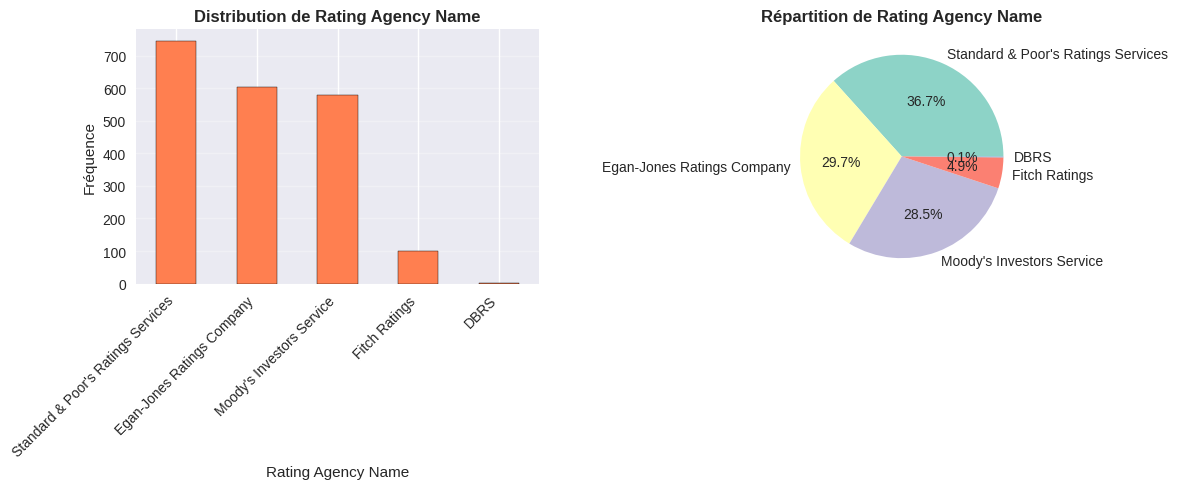


Répartition de Rating Agency Name:
  Standard & Poor's Ratings Services:  744 ( 36.7%)
  Egan-Jones Ratings Company    :  603 ( 29.7%)
  Moody's Investors Service     :  579 ( 28.5%)
  Fitch Ratings                 :  100 (  4.9%)
  DBRS                          :    3 (  0.1%)



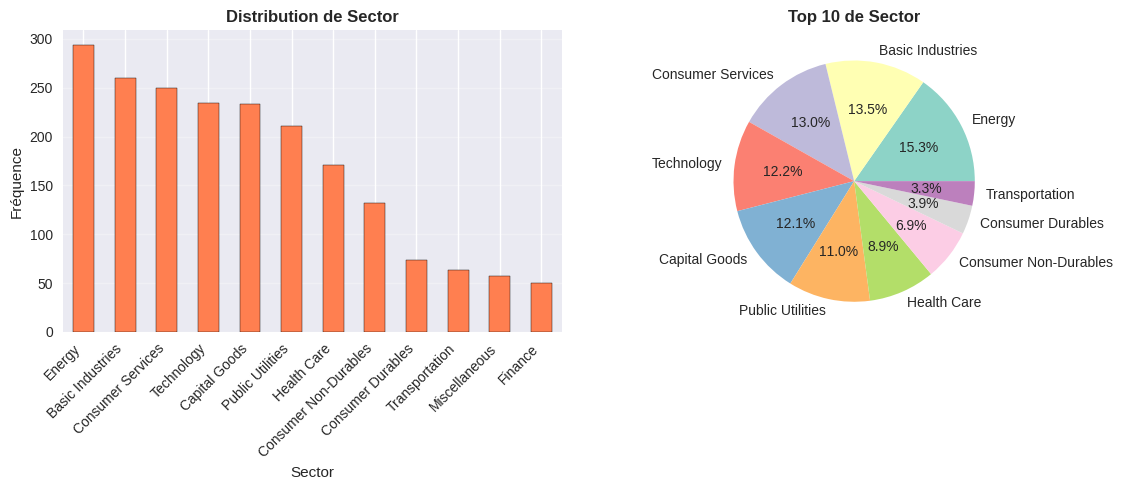


Répartition de Sector:
  Energy                        :  294 ( 14.5%)
  Basic Industries              :  260 ( 12.8%)
  Consumer Services             :  250 ( 12.3%)
  Technology                    :  234 ( 11.5%)
  Capital Goods                 :  233 ( 11.5%)
  Public Utilities              :  211 ( 10.4%)
  Health Care                   :  171 (  8.4%)
  Consumer Non-Durables         :  132 (  6.5%)
  Consumer Durables             :   74 (  3.6%)
  Transportation                :   63 (  3.1%)
  Miscellaneous                 :   57 (  2.8%)
  Finance                       :   50 (  2.5%)



In [67]:
# Distribution des variables catégorielles
if len(other_categorical) > 0:
    print("\n=== DISTRIBUTIONS DES VARIABLES CATÉGORIELLES ===\n")
    
    for col in other_categorical:
        plt.figure(figsize=(12, 5))
        
        value_counts = df[col].value_counts()
        
        # Barplot
        plt.subplot(1, 2, 1)
        value_counts.plot(kind='bar', color='coral', edgecolor='black')
        plt.title(f'Distribution de {col}', fontweight='bold')
        plt.xlabel(col)
        plt.ylabel('Fréquence')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Pie chart
        plt.subplot(1, 2, 2)
        if len(value_counts) <= 10:  # Seulement si pas trop de catégories
            value_counts.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Set3.colors)
            plt.title(f'Répartition de {col}', fontweight='bold')
            plt.ylabel('')
        else:
            # Si trop de catégories, montrer juste le top 10
            value_counts.head(10).plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Set3.colors)
            plt.title(f'Top 10 de {col}', fontweight='bold')
            plt.ylabel('')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nRépartition de {col}:")
        for value, count in value_counts.items():
            print(f"  {value:30s}: {count:4d} ({count/len(df)*100:5.1f}%)")
        print()
else:
    print("\nAucune variable catégorielle (hors cible) trouvée.")

### Matrice de corrélation globale

Rapide matrice ayant pour objectif de voir les liens entre les différentes features.


=== MATRICE DE CORRÉLATION ===


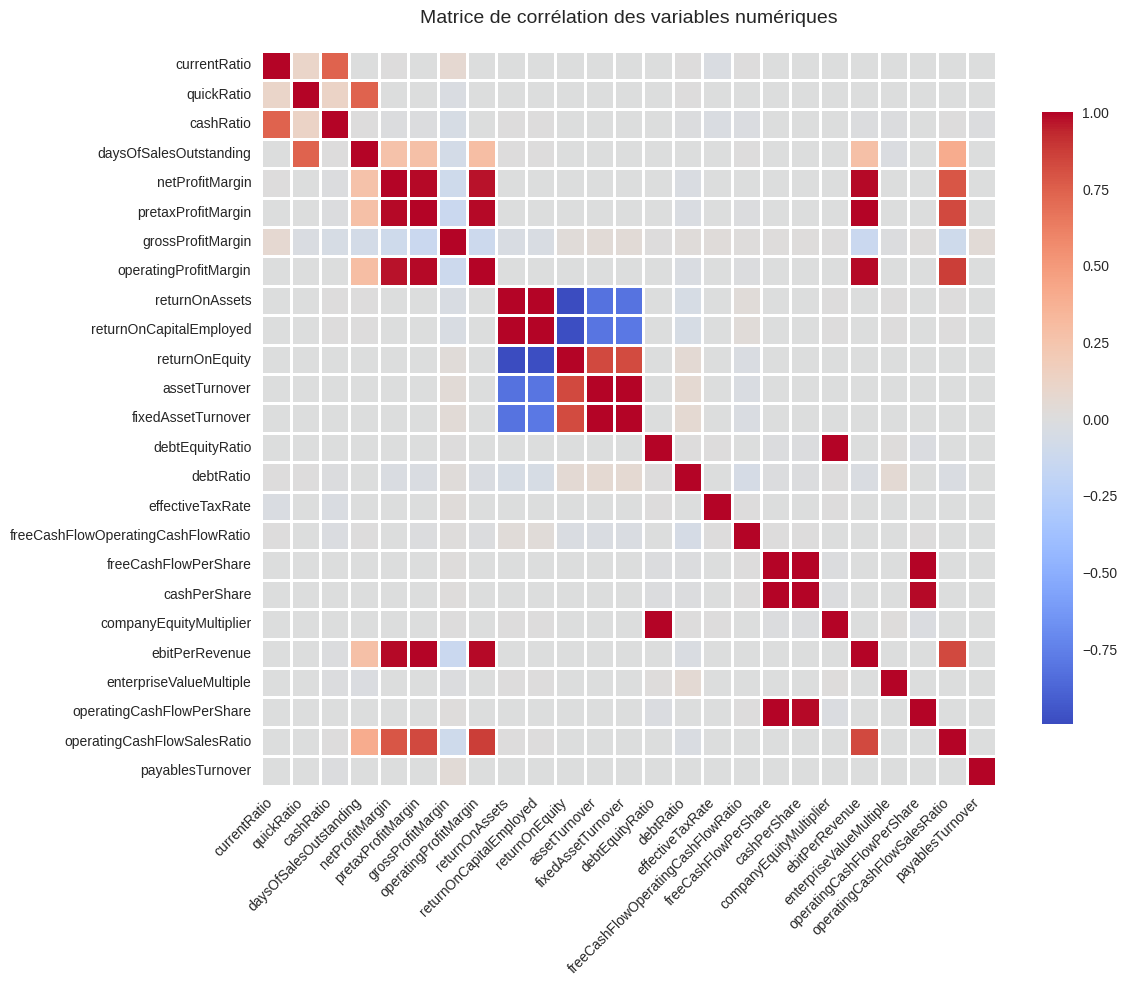


Top 10 des corrélations les plus fortes (hors diagonale):
  1. companyEquityMultiplier <-> debtEquityRatio: 1.000
  2. ebitPerRevenue <-> pretaxProfitMargin: 1.000
  3. fixedAssetTurnover <-> assetTurnover: 1.000
  4. cashPerShare <-> freeCashFlowPerShare: 0.997
  5. returnOnCapitalEmployed <-> returnOnAssets: 0.995
  6. returnOnEquity <-> returnOnAssets: -0.995
  7. operatingCashFlowPerShare <-> freeCashFlowPerShare: 0.992
  8. ebitPerRevenue <-> operatingProfitMargin: 0.992
  9. operatingProfitMargin <-> pretaxProfitMargin: 0.992
  10. pretaxProfitMargin <-> netProfitMargin: 0.991


In [68]:
# Matrice de corrélation
if len(numeric_cols) > 1:
    print("\n=== MATRICE DE CORRÉLATION ===")
    
    # Calculer la matrice de corrélation
    corr_matrix = df[numeric_cols].corr()
    
    # Afficher la heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8})
    plt.title('Matrice de corrélation des variables numériques', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Afficher les corrélations les plus fortes (hors diagonale)
    print("\nTop 10 des corrélations les plus fortes (hors diagonale):")
    # Extraire le triangle supérieur de la matrice
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Convertir en série et trier
    correlations_list = upper_triangle.unstack().dropna().abs().sort_values(ascending=False)
    
    for i, ((var1, var2), corr_val) in enumerate(correlations_list.head(10).items()):
        actual_corr = corr_matrix.loc[var1, var2]
        print(f"  {i+1}. {var1} <-> {var2}: {actual_corr:.3f}")
else:
    print("Pas assez de variables numériques pour une matrice de corrélation.")

## Distribution de la Variable Cible

C'est la première chose à regarder dans un problème de classification ! Il faut comprendre si notre dataset est équilibré ou non.

**Pourquoi c'est important pour la Prédiction Conforme :**

- **Déséquilibre des classes** : Si certaines classes sont rares, le modèle aura plus de mal à les prédire correctement
- **Taille des ensembles de prédiction** : Les classes minoritaires risquent d'apparaître plus souvent dans les ensembles de prédiction (pour garder la garantie de couverture)
- **Calibration** : Un fort déséquilibre peut nécessiter des ajustements dans la méthode de prédiction conforme (stratification, pondération)
- **Interprétation** : Ça nous aide à comprendre si un ensemble de prédiction avec plusieurs classes est normal ou problématique

=== DISTRIBUTION DE LA VARIABLE CIBLE ===


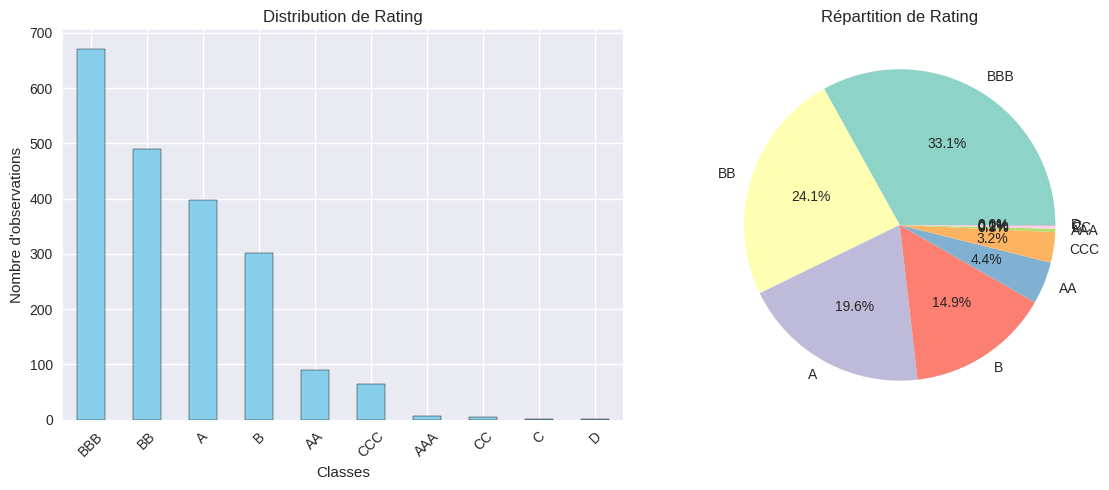


Répartition par classe:
  BBB: 671 (33.1%)
  BB: 490 (24.1%)
  A: 398 (19.6%)
  B: 302 (14.9%)
  AA: 89 (4.4%)
  CCC: 64 (3.2%)
  AAA: 7 (0.3%)
  CC: 5 (0.2%)
  C: 2 (0.1%)
  D: 1 (0.0%)


In [69]:
# 1. Distribution de la variable cible
print("=== DISTRIBUTION DE LA VARIABLE CIBLE ===")
class_counts = df[target_col].value_counts()

plt.figure(figsize=(12, 5))

# Barplot
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f'Distribution de {target_col}')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 2, 2)
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Set3.colors)
plt.title(f'Répartition de {target_col}')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\nRépartition par classe:")
for classe, count in class_counts.items():
    print(f"  {classe}: {count} ({count/len(df)*100:.1f}%)")

### Déséquilibre de la variable cible

Comme on le voit ci-dessus, certaines classes sont gravement sous représentées (D, C, CC, AAA), ce qui risque fortement de nuire à nos modèles. 

C'est pourquoi nous allons retravailler ces classes pour les regrouper par niveau d'investissements, ce qui reste très utile si ce n'est même plus pour le context métier des banques, c'est à dire savoir rapidement si un profil est sujet à investissement ou non car trop risqué.

In [70]:
from preprocessing import group_credit_ratings

df['Grouped_Rating'] = group_credit_ratings(df[target_col])

Regroupement des ratings de crédit...
Distribution originale:
Rating
A      398
AA      89
AAA      7
B      302
BB     490
BBB    671
C        2
CC       5
CCC     64
D        1
Name: count, dtype: int64

Distribution après regroupement:
Rating
IG_HIGH       96
IG_LOW       671
IG_MED       398
SPEC_HIGH    490
SPEC_LOW      72
SPEC_MED     302
Name: count, dtype: int64


## Distribution de la Variable Cible Regroupée

Après regroupement, nous avons maintenant **6 classes** au lieu de 10, ce qui améliore considérablement l'équilibre du dataset :

**Investment Grade (IG)** - Entreprises de bonne qualité :
- **IG_HIGH** (AAA, AA) : Très haute qualité, risque très faible
- **IG_MED** (A) : Haute qualité, risque faible
- **IG_LOW** (BBB) : Qualité satisfaisante, risque modéré

**Speculative Grade (SPEC)** - Entreprises plus risquées :
- **SPEC_HIGH** (BB) : Modérément spéculatif
- **SPEC_MED** (B) : Spéculatif
- **SPEC_LOW** (CCC, CC, C, D) : Très spéculatif ou en défaut

Ce regroupement est plus adapté pour :
- Réduire le déséquilibre entre classes
- Avoir plus d'échantillons par classe pour un meilleur apprentissage
- Obtenir des ensembles de prédiction plus pertinents avec la Prédiction Conforme

=== DISTRIBUTION DE LA VARIABLE CIBLE REGROUPÉE ===


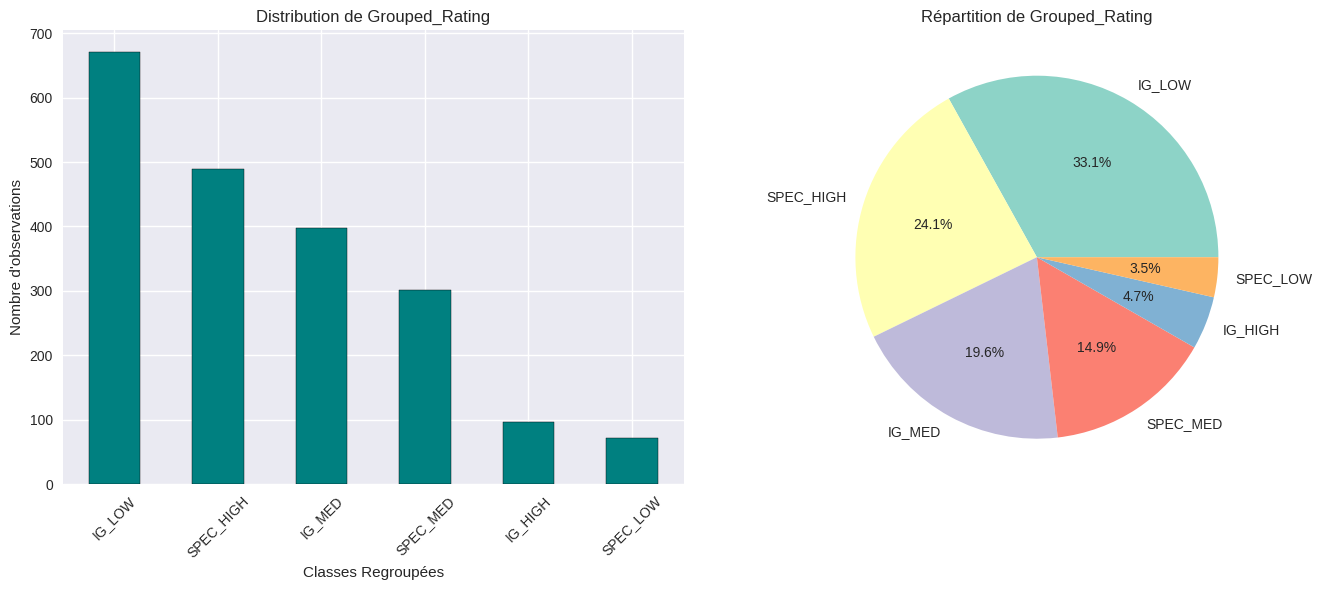


Répartition par classe regroupée:
  IG_LOW: 671 (33.1%)
  SPEC_HIGH: 490 (24.1%)
  IG_MED: 398 (19.6%)
  SPEC_MED: 302 (14.9%)
  IG_HIGH: 96 (4.7%)
  SPEC_LOW: 72 (3.5%)

=== COMPARAISON ORIGINAL vs REGROUPÉ ===
Nombre de classes original: 10
Nombre de classes regroupées: 6

Classe la plus rare (original): 1 observations
Classe la plus rare (regroupé): 72 observations

Ratio max/min (original): 671.0x
Ratio max/min (regroupé): 9.3x


In [71]:
# Distribution de la variable cible regroupée
print("=== DISTRIBUTION DE LA VARIABLE CIBLE REGROUPÉE ===")
grouped_class_counts = df['Grouped_Rating'].value_counts()

plt.figure(figsize=(14, 6))

# Barplot
plt.subplot(1, 2, 1)
grouped_class_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Distribution de Grouped_Rating')
plt.xlabel('Classes Regroupées')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 2, 2)
grouped_class_counts.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Set3.colors)
plt.title('Répartition de Grouped_Rating')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\nRépartition par classe regroupée:")
for classe, count in grouped_class_counts.items():
    print(f"  {classe}: {count} ({count/len(df)*100:.1f}%)")

# Comparaison avec la distribution originale
print("\n=== COMPARAISON ORIGINAL vs REGROUPÉ ===")
print(f"Nombre de classes original: {df[target_col].nunique()}")
print(f"Nombre de classes regroupées: {df['Grouped_Rating'].nunique()}")
print(f"\nClasse la plus rare (original): {df[target_col].value_counts().min()} observations")
print(f"Classe la plus rare (regroupé): {df['Grouped_Rating'].value_counts().min()} observations")
print(f"\nRatio max/min (original): {df[target_col].value_counts().max() / df[target_col].value_counts().min():.1f}x")
print(f"Ratio max/min (regroupé): {df['Grouped_Rating'].value_counts().max() / df['Grouped_Rating'].value_counts().min():.1f}x")

/tmp/ipykernel_86309/3209239668.py:48: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/r-one/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


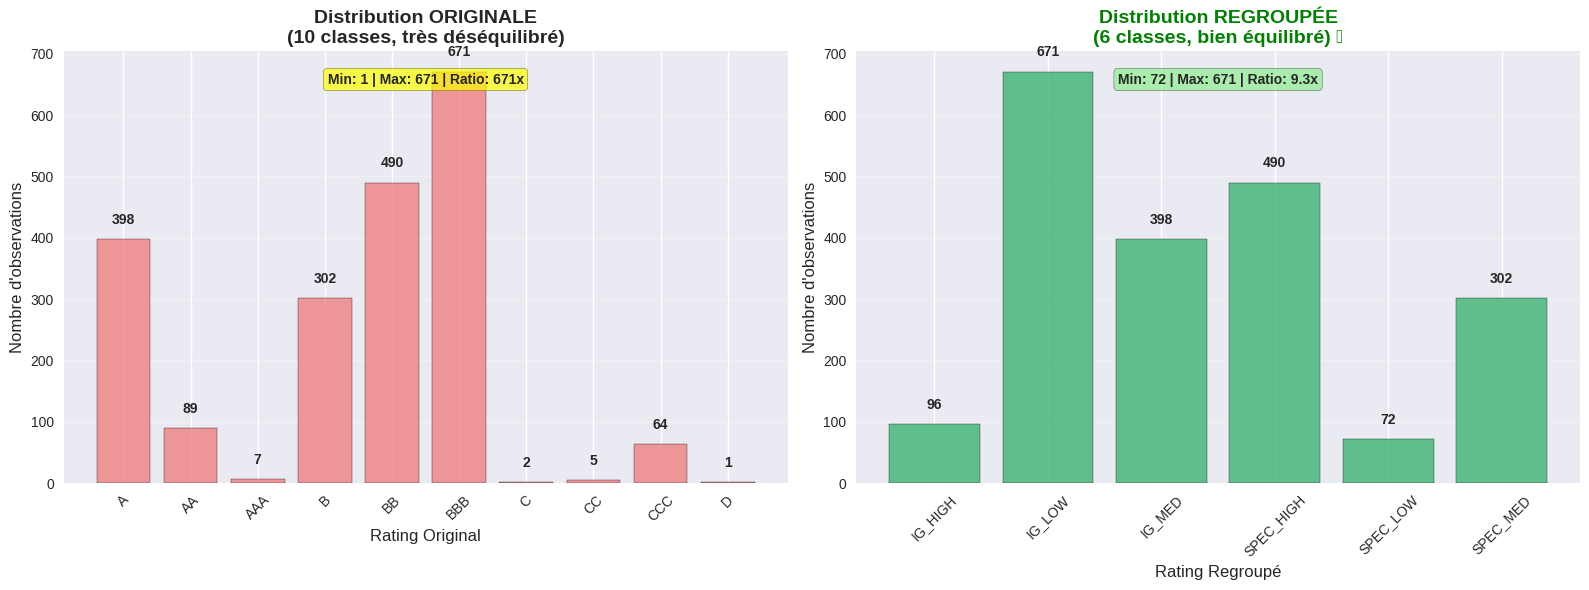

In [72]:
# Visualisation comparative finale : Original vs Regroupé
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution originale
original_counts = df[target_col].value_counts().sort_index()
axes[0].bar(range(len(original_counts)), original_counts.values, 
           color='lightcoral', edgecolor='black', alpha=0.8)
axes[0].set_xticks(range(len(original_counts)))
axes[0].set_xticklabels(original_counts.index, rotation=45)
axes[0].set_title('Distribution ORIGINALE\n(10 classes, très déséquilibré)', 
                 fontweight='bold', fontsize=14)
axes[0].set_xlabel('Rating Original', fontsize=12)
axes[0].set_ylabel('Nombre d\'observations', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Annoter les valeurs
for i, v in enumerate(original_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Ajouter des statistiques
axes[0].text(0.5, 0.95, f'Min: {original_counts.min()} | Max: {original_counts.max()} | Ratio: {original_counts.max()/original_counts.min():.0f}x',
            transform=axes[0].transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            fontsize=10, fontweight='bold')

# Distribution regroupée
grouped_counts = df['Grouped_Rating'].value_counts().sort_index()
axes[1].bar(range(len(grouped_counts)), grouped_counts.values, 
           color='mediumseagreen', edgecolor='black', alpha=0.8)
axes[1].set_xticks(range(len(grouped_counts)))
axes[1].set_xticklabels(grouped_counts.index, rotation=45)
axes[1].set_title('Distribution REGROUPÉE\n(6 classes, bien équilibré) ✅', 
                 fontweight='bold', fontsize=14, color='green')
axes[1].set_xlabel('Rating Regroupé', fontsize=12)
axes[1].set_ylabel('Nombre d\'observations', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Annoter les valeurs
for i, v in enumerate(grouped_counts.values):
    axes[1].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Ajouter des statistiques
axes[1].text(0.5, 0.95, f'Min: {grouped_counts.min()} | Max: {grouped_counts.max()} | Ratio: {grouped_counts.max()/grouped_counts.min():.1f}x',
            transform=axes[1].transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Analyse Bivariée : Variables numériques avec la Variable Regroupée

Maintenant, analysons comment les variables numériques discriminent les nouvelles classes regroupées. Cela nous permettra de voir si le regroupement facilite la séparation des classes.


=== ANALYSE BIVARIÉE : VARIABLES NUMÉRIQUES vs GROUPED_RATING ===

📊 Boxplots - Distribution par classe


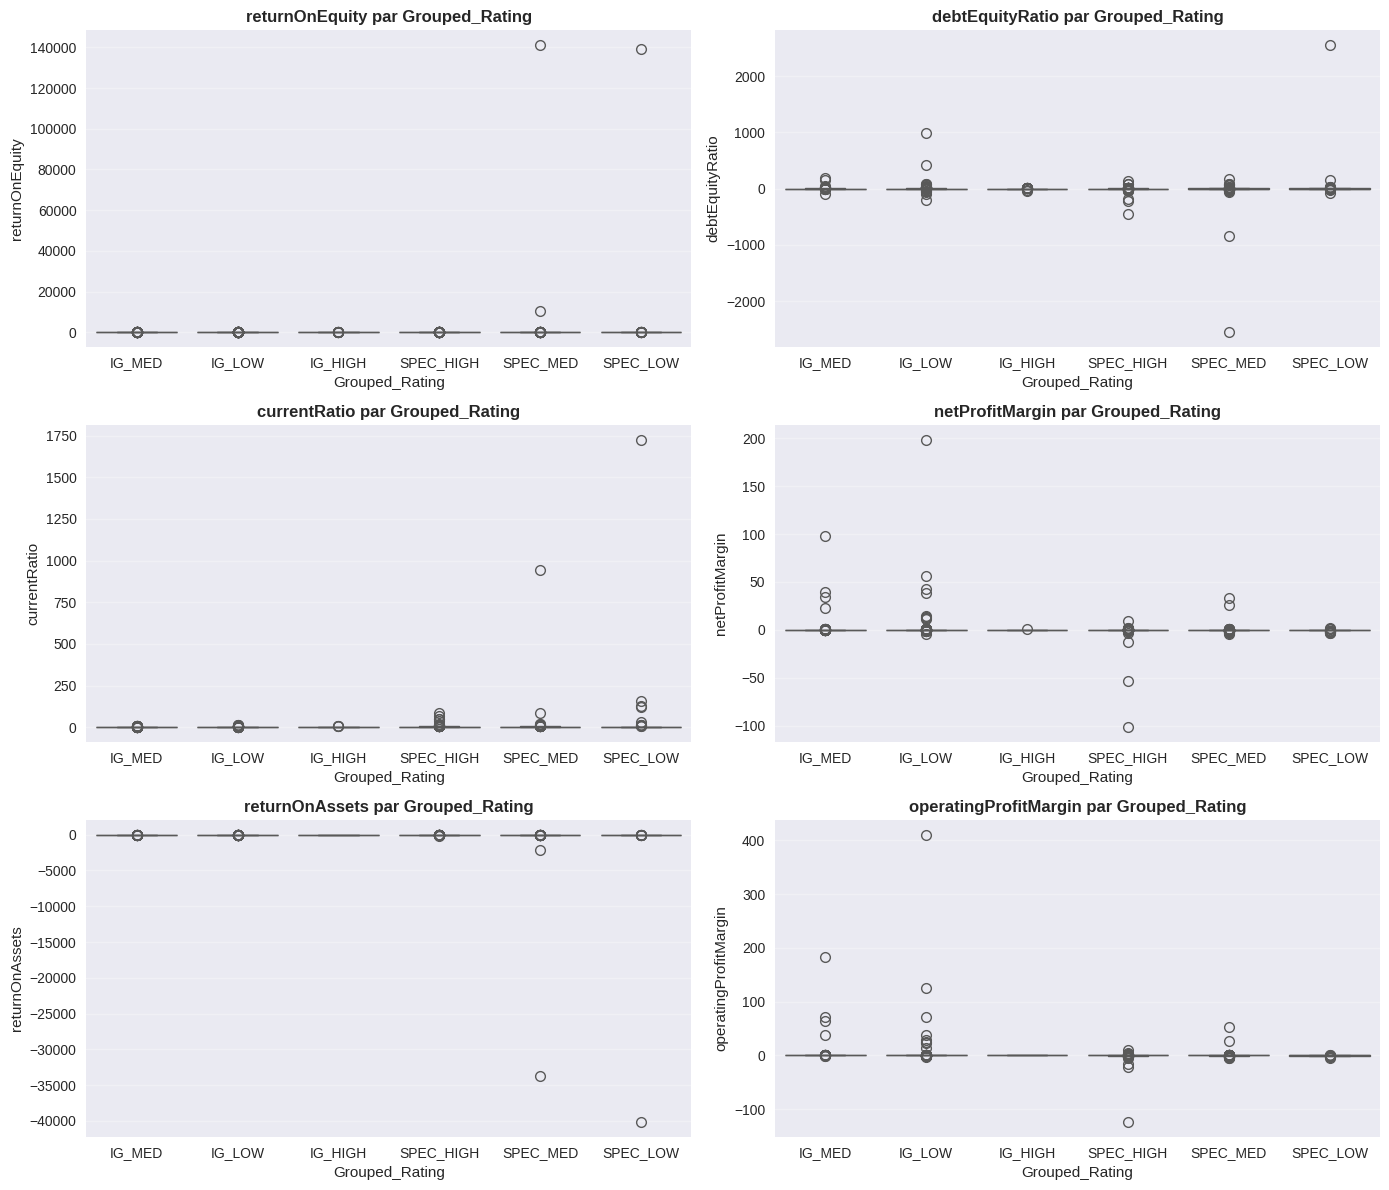


📊 Moyennes par classe


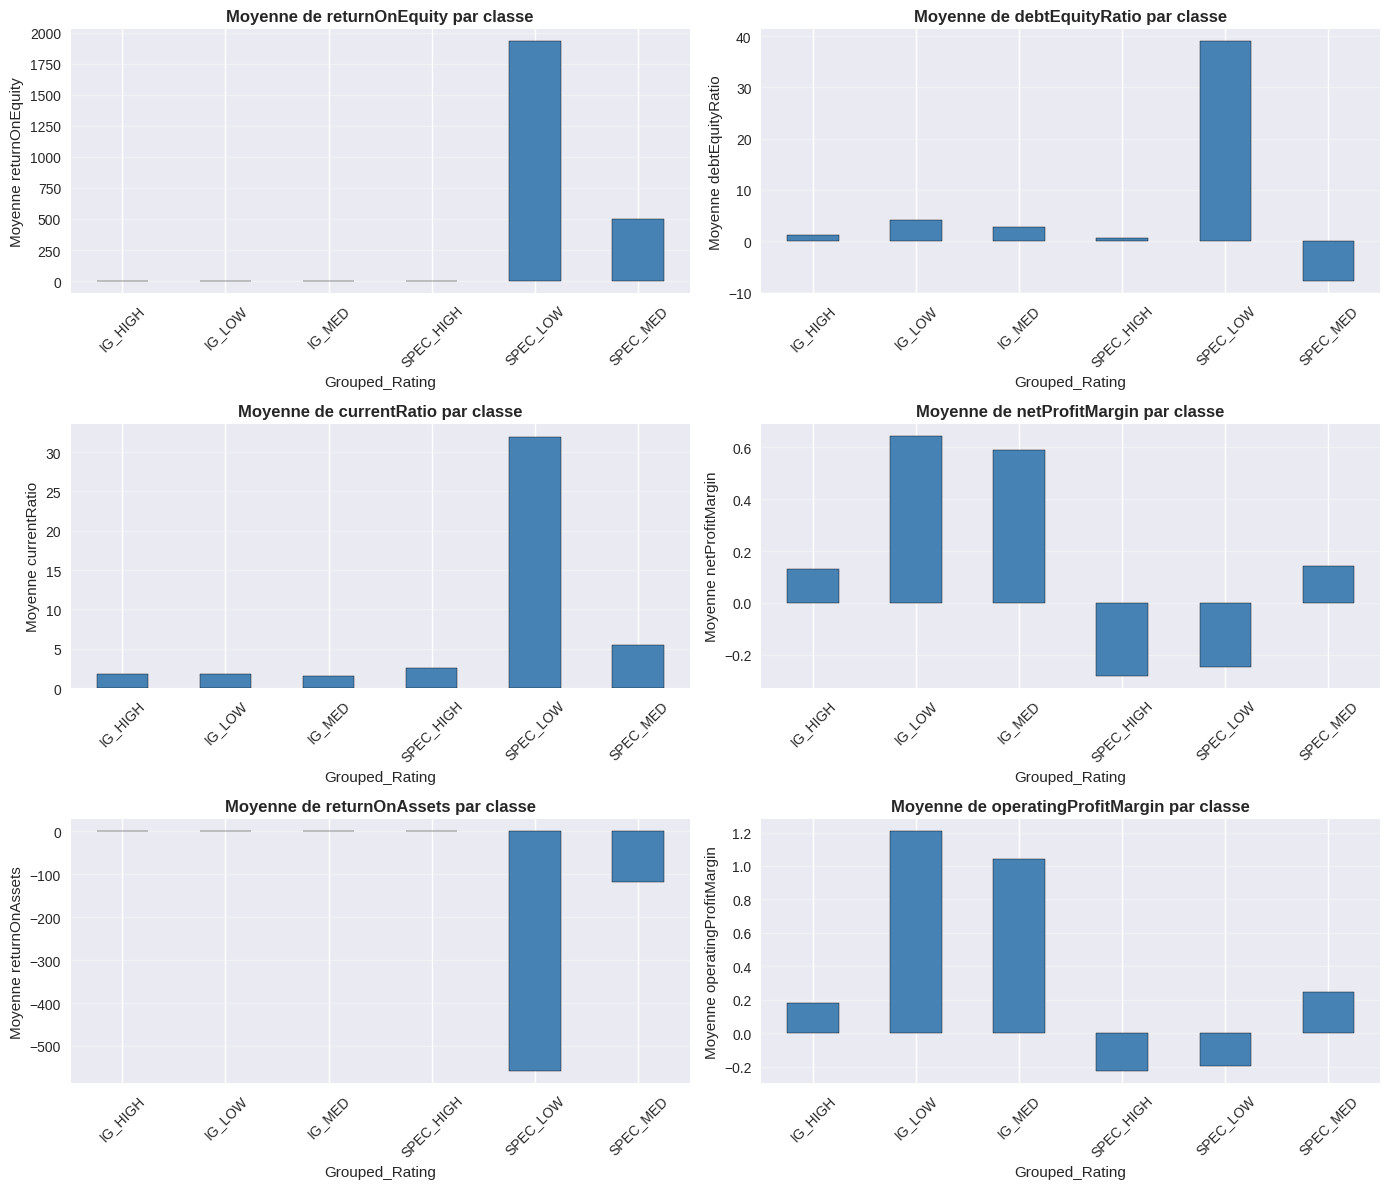


📈 Statistiques des variables clés par classe regroupée:

returnOnEquity:
                    mean  median        std
Grouped_Rating                             
IG_HIGH            0.200   0.187      0.588
IG_LOW             0.346   0.128      3.615
IG_MED             0.361   0.169      2.247
SPEC_HIGH         -0.211   0.090      3.559
SPEC_LOW        1930.643   0.002  16384.702
SPEC_MED         502.823   0.056   8154.431

debtEquityRatio:
                  mean  median      std
Grouped_Rating                         
IG_HIGH          1.231   1.273    5.109
IG_LOW           4.169   1.673   42.939
IG_MED           2.817   1.593   13.455
SPEC_HIGH        0.495   1.600   26.103
SPEC_LOW        38.987   2.213  302.272
SPEC_MED        -7.823   2.093  155.466

currentRatio:
                  mean  median      std
Grouped_Rating                         
IG_HIGH          1.764   1.512    0.879
IG_LOW           1.754   1.434    1.295
IG_MED           1.539   1.339    0.953
SPEC_HIGH        2.58

In [76]:
# Analyse bivariée - Variables numériques vs Grouped_Rating
if len(numeric_cols) > 0:
    print("\n=== ANALYSE BIVARIÉE : VARIABLES NUMÉRIQUES vs GROUPED_RATING ===")
    
    # Sélection de quelques variables clés pour la visualisation
    key_vars = ['returnOnEquity', 'debtEquityRatio', 'currentRatio', 'netProfitMargin', 
                'returnOnAssets', 'operatingProfitMargin']
    key_vars = [v for v in key_vars if v in numeric_cols]
    
    if len(key_vars) > 0:
        # 1. BOXPLOTS SIMPLES - Une visualisation claire et efficace
        print("\n📊 Boxplots - Distribution par classe")
        n_cols = 2
        n_rows = (len(key_vars) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
        
        if len(key_vars) == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes if n_cols > 1 else [axes]
        else:
            axes = axes.ravel()
        
        for i, col in enumerate(key_vars):
            if i < len(axes):
                sns.boxplot(data=df, x='Grouped_Rating', y=col, hue='Grouped_Rating', 
                           ax=axes[i], palette='Set2', legend=False)
                axes[i].set_title(f'{col} par Grouped_Rating', fontweight='bold')
                axes[i].set_xlabel('Grouped_Rating')
                axes[i].set_ylabel(col)
                axes[i].grid(True, alpha=0.3, axis='y')
        
        # Masquer les axes vides
        for i in range(len(key_vars), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # 2. MOYENNES PAR CLASSE - Graphique en barres
        print("\n📊 Moyennes par classe")
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
        
        if len(key_vars) == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes if n_cols > 1 else [axes]
        else:
            axes = axes.ravel()
        
        for i, col in enumerate(key_vars):
            if i < len(axes):
                means = df.groupby('Grouped_Rating')[col].mean().sort_index()
                means.plot(kind='bar', ax=axes[i], color='steelblue', edgecolor='black')
                axes[i].set_title(f'Moyenne de {col} par classe', fontweight='bold')
                axes[i].set_xlabel('Grouped_Rating')
                axes[i].set_ylabel(f'Moyenne {col}')
                axes[i].tick_params(axis='x', rotation=45)
                axes[i].grid(True, alpha=0.3, axis='y')
        
        # Masquer les axes vides
        for i in range(len(key_vars), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # 3. Statistiques par classe regroupée
        print("\n📈 Statistiques des variables clés par classe regroupée:")
        for col in key_vars:
            print(f"\n{col}:")
            stats = df.groupby('Grouped_Rating')[col].agg(['mean', 'median', 'std']).round(3)
            print(stats)
        
        # 4. Analyse de la séparabilité des classes (ANOVA)
        from scipy import stats
        print(f"\n🔬 Test ANOVA - Variables discriminantes:")
        separability_results = []
        unique_classes = sorted(df['Grouped_Rating'].unique())
        
        for col in key_vars:
            groups = [df[df['Grouped_Rating'] == class_val][col].dropna() for class_val in unique_classes]
            f_stat, p_value = stats.f_oneway(*groups)
            separability_results.append({
                'Variable': col,
                'F-statistic': f_stat,
                'p-value': p_value,
            })
        
        # Tableau récapitulatif
        sep_df = pd.DataFrame(separability_results).sort_values('F-statistic', ascending=False)
        print("\n📊 Récapitulatif du pouvoir discriminant:")
        print(sep_df.to_string(index=False))
                
else:
    print("Aucune variable numérique pour l'analyse bivariée.")

## Analyse Bivariée : Variables Catégorielles avec la variable cible regroupée

Analysons comment les variables catégorielles (comme le secteur) se distribuent dans les différentes classes regroupées.


=== ANALYSE BIVARIÉE : VARIABLES CATÉGORIELLES vs GROUPED_RATING ===

Rating Agency Name vs Grouped_Rating:
Effectifs:
Grouped_Rating                      IG_HIGH  IG_LOW  IG_MED  SPEC_HIGH  \
Rating Agency Name                                                       
DBRS                                      2       1       0          0   
Egan-Jones Ratings Company               68     168     209         99   
Fitch Ratings                             3      48      17         22   
Moody's Investors Service                 7     243     105        102   
Standard & Poor's Ratings Services       16     211      67        267   

Grouped_Rating                      SPEC_LOW  SPEC_MED  
Rating Agency Name                                      
DBRS                                       0         0  
Egan-Jones Ratings Company                12        47  
Fitch Ratings                              3         7  
Moody's Investors Service                 35        87  
Standard & Poor's R

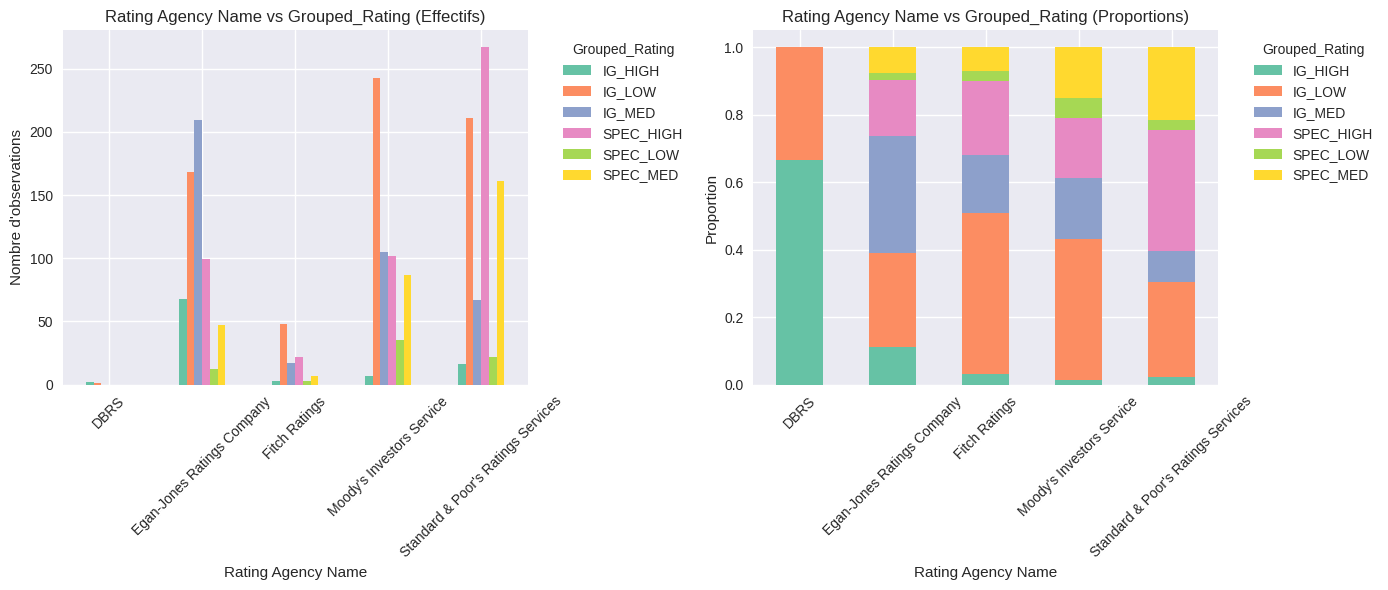


Sector vs Grouped_Rating:
Effectifs:
Grouped_Rating         IG_HIGH  IG_LOW  IG_MED  SPEC_HIGH  SPEC_LOW  SPEC_MED
Sector                                                                       
Basic Industries             0      99      20         71         7        63
Capital Goods                8      89      48         53        10        25
Consumer Durables            0      26      11         26         0        11
Consumer Non-Durables        7      35      53         24         2        11
Consumer Services            6      66      32         84         9        53
Energy                      21      96      42         61        17        57
Finance                      0      18      17          7         5         3
Health Care                 15      56      37         27        12        24
Miscellaneous                0      24      12         16         0         5
Public Utilities             9      93      66         32         0        11
Technology                

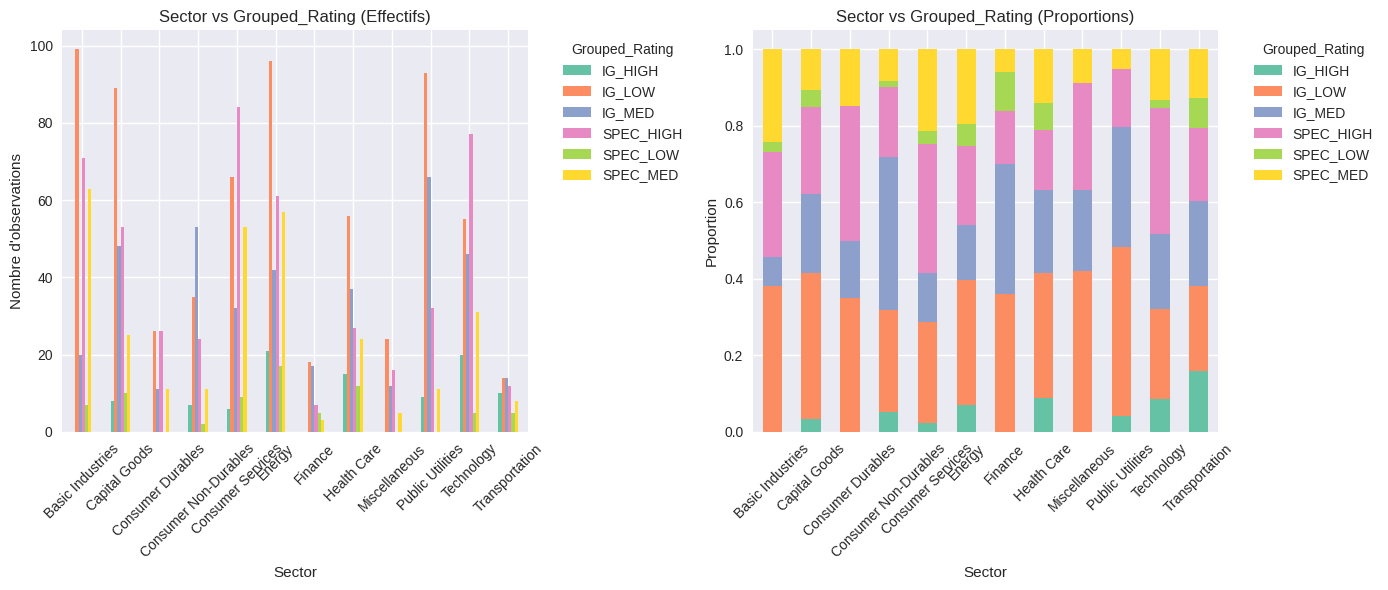

In [74]:
# Analyse bivariée - Variables catégorielles vs Grouped_Rating
if len(other_categorical) > 0:
    print("\n=== ANALYSE BIVARIÉE : VARIABLES CATÉGORIELLES vs GROUPED_RATING ===")
    
    for col in other_categorical:
        # Table de contingence
        crosstab = pd.crosstab(df[col], df['Grouped_Rating'])
        crosstab_norm = pd.crosstab(df[col], df['Grouped_Rating'], normalize='index')
        
        print(f"\n{col} vs Grouped_Rating:")
        print("Effectifs:")
        print(crosstab)
        print("\nProportions par ligne:")
        print(crosstab_norm.round(3))
        
        # Graphique empilé
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        crosstab.plot(kind='bar', ax=plt.gca(), color=plt.cm.Set2.colors)
        plt.title(f'{col} vs Grouped_Rating (Effectifs)')
        plt.xlabel(col)
        plt.ylabel('Nombre d\'observations')
        plt.xticks(rotation=45)
        plt.legend(title='Grouped_Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.subplot(1, 2, 2)
        crosstab_norm.plot(kind='bar', stacked=True, ax=plt.gca(), color=plt.cm.Set2.colors)
        plt.title(f'{col} vs Grouped_Rating (Proportions)')
        plt.xlabel(col)
        plt.ylabel('Proportion')
        plt.xticks(rotation=45)
        plt.legend(title='Grouped_Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
else:
    print("Aucune variable catégorielle (hors cible) pour l'analyse bivariée.")

## Synthèse de l'Analyse avec Variables Regroupées

### Avantages du regroupement :

**Équilibre amélioré** : Le ratio max/min entre classes est bien meilleur

**Classes plus robustes** : Chaque classe a suffisamment d'échantillons pour l'apprentissage

**Interprétabilité** : Les 6 classes correspondent à des niveaux de risque métier clairs :
   - **IG** (Investment Grade) : Entreprises fiables, faible risque
   - **SPEC** (Speculative) : Entreprises plus risquées, potentiel de défaut

### Pour la Prédiction Conforme :

- **Ensembles de prédiction plus précis** : Avec de meilleures classes, les scores de non-conformité seront plus fiables
- **Couverture garantie** : La garantie statistique sera maintenue même avec moins de classes
- **Interprétation métier** : Un ensemble comme {IG_LOW, SPEC_HIGH} signifie "limite Investment/Speculative"
- **Taille des ensembles** : Attendons-nous à des ensembles de 1-2 classes pour les prédictions confiantes

## matrice de corrélation entre les features et la variables cible


=== CORRÉLATION ENTRE VARIABLES NUMÉRIQUES ET GROUPED_RATING ===


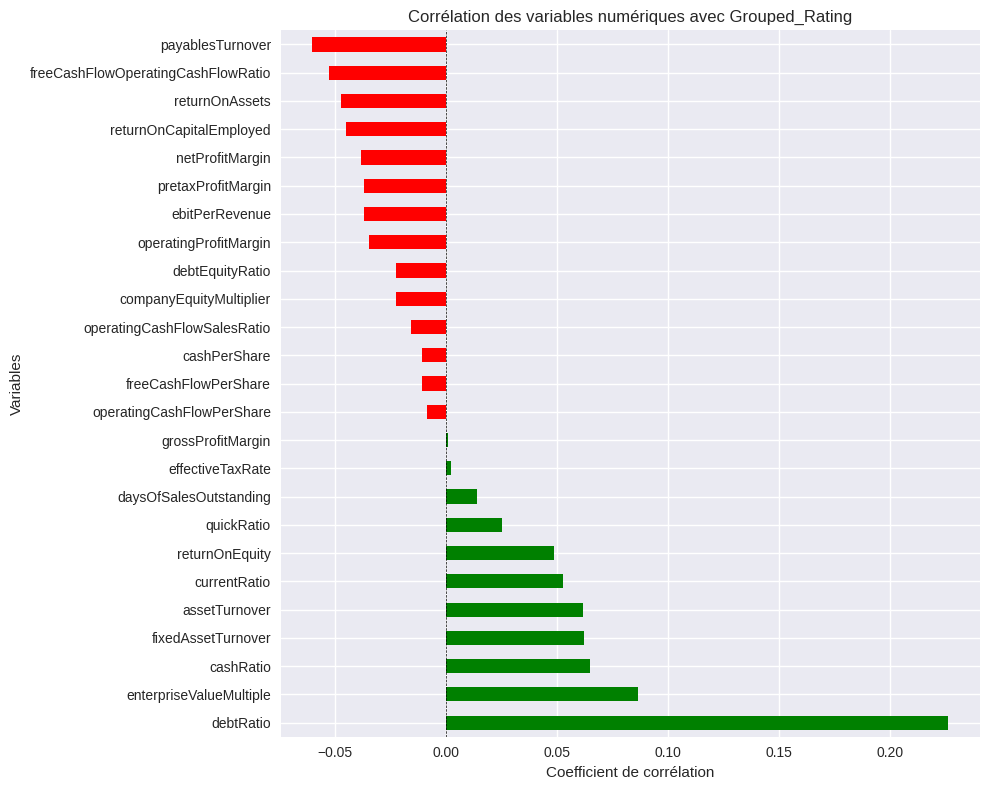


Top 10 variables les plus corrélées (positivement):
debtRatio                  0.226214
enterpriseValueMultiple    0.086366
cashRatio                  0.065102
fixedAssetTurnover         0.062129
assetTurnover              0.061907
currentRatio               0.052710
returnOnEquity             0.048738
quickRatio                 0.025138
daysOfSalesOutstanding     0.014011
effectiveTaxRate           0.002332
Name: Grouped_Rating_encoded, dtype: float64

Top 10 variables les plus corrélées (négativement):
companyEquityMultiplier              -0.022476
debtEquityRatio                      -0.022531
operatingProfitMargin                -0.034772
ebitPerRevenue                       -0.036859
pretaxProfitMargin                   -0.036935
netProfitMargin                      -0.038374
returnOnCapitalEmployed              -0.045049
returnOnAssets                       -0.047137
freeCashFlowOperatingCashFlowRatio   -0.052630
payablesTurnover                     -0.060023
Name: Grouped_Ratin

In [75]:
# Heatmap de corrélation entre les classes regroupées et les variables numériques
print("\n=== CORRÉLATION ENTRE VARIABLES NUMÉRIQUES ET GROUPED_RATING ===")

# Encoder temporairement Grouped_Rating pour calculer les corrélations
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_temp = df.copy()
df_temp['Grouped_Rating_encoded'] = le.fit_transform(df_temp['Grouped_Rating'])

# Créer une liste avec les colonnes numériques et la colonne encodée
cols_to_correlate = list(numeric_cols) + ['Grouped_Rating_encoded']

# Calculer les corrélations
correlations = df_temp[cols_to_correlate].corr()['Grouped_Rating_encoded'].drop('Grouped_Rating_encoded').sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlations])
plt.title('Corrélation des variables numériques avec Grouped_Rating')
plt.xlabel('Coefficient de corrélation')
plt.ylabel('Variables')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nTop 10 variables les plus corrélées (positivement):")
print(correlations.head(10))

print("\nTop 10 variables les plus corrélées (négativement):")
print(correlations.tail(10))

## Conclusion de l'EDA

### Résultats clés :

**1. Amélioration du déséquilibre :**
- Passage de 10 à 6 classes
- Ratio max/min : de 671x à seulement 9.3x 
- Classe minimale : de 1 à 72 observations

**2. Variables discriminantes identifiées :**

**Corrélations positives** (meilleur rating quand la valeur augmente) :
- `debtRatio` : Les entreprises bien notées ont tendance à avoir des ratios de dette plus élevés mais maîtrisés
- `enterpriseValueMultiple`, `cashRatio`, `currentRatio` : Indicateurs de solidité financière

**Corrélations négatives** (meilleur rating quand la valeur diminue) :
- Variables de rentabilité (`returnOnAssets`, `returnOnCapitalEmployed`, `netProfitMargin`) : Contre-intuitif, peut indiquer que les grandes entreprises stables (IG) ont des marges plus faibles mais sont plus fiables
- `payablesTurnover` : Rotation des dettes fournisseurs

**4. Variables catégorielles :**
- **Secteur** : Certains secteurs (Technology, Public Utilities) tendent vers de meilleurs ratings
- **Rating Agency** : Distribution relativement cohérente entre agences